In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

/home/saulius/.virtualenvs/scientific-py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
import string
random = np.random.RandomState(11116)
n_points = 30
data = random.randn(n_points, n_points)

def random_word(length):
    letters = list(string.ascii_lowercase)
    letters_and_spaces = letters + [' ']
    
    if length < 3:
        label = ''.join(random.choice(letters, size=length))
    else:
        label = random.choice(letters)
        # allow spaces but not in first or last letter
        label += ''.join(random.choice(letters_and_spaces, size=length - 2))
        label += random.choice(letters)
        
    return label    

min_length = 5
max_length = 20 

labels = list(map(random_word, random.randint(min_length, max_length+1, size=n_points)))


In [6]:
from cleanlabels.cleanlabels import arrange_labels, collect_point_bboxes, collect_text_bboxes, adjust_bboxes, LabelAnnealer, energy
from cleanlabels.geometry import make_qtree

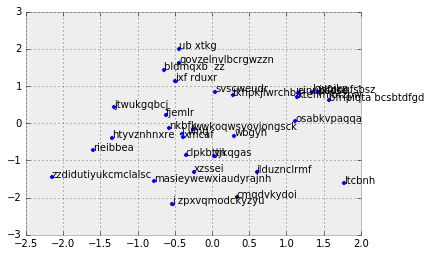

In [7]:
plt.figure()

ax = plt.gca()
point_radius=0.05
renderer = ax.get_figure().canvas.get_renderer()

anchor_x = data[0]
anchor_y = data[1]

ax.scatter(anchor_x, anchor_y)

text_objects = []
anchors = []
other_points = []
for x, y, label in zip(anchor_x, anchor_y, labels):
    point = np.array([x, y])
    if label:
        anchors.append(np.array([x, y]))
        text_objects.append(ax.text(x, y, label))
    else:
        other_points.append(point)

label_bboxes = collect_text_bboxes(text_objects, ax, renderer)
other_bboxes = collect_point_bboxes(anchors + other_points, point_radius=point_radius)

other_bboxes_qtree = make_qtree(other_bboxes)

initial_state = np.zeros(len(label_bboxes) * 2)

# adjusted_boxes = adjust_bboxes(initial_state, label_bboxes, anchors)
# for text, box in zip(text_objects,
#                      adjusted_boxes):

#     text.set_position([box.x_min, box.y_min])

In [8]:
initial_state

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [9]:
def objective(bboxes, anchors, other_bboxes_qtree, **energy_kwargs):
    
    def f(state):
        new_bboxes = adjust_bboxes(state, bboxes, anchors)
        total_energy = energy(new_bboxes, anchors, other_bboxes_qtree, **energy_kwargs)
        return total_energy
    
    return f

In [10]:
func = objective(label_bboxes, anchors, other_bboxes_qtree)

In [11]:
func(initial_state)

65.203842458957723

In [12]:
from scipy.optimize import fmin, minimize, basinhopping

In [13]:
ans_simple = minimize(func, initial_state)

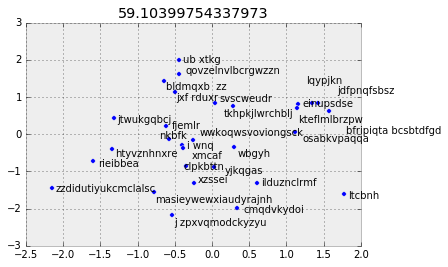

In [14]:
plt.figure()

ax = plt.gca()
point_radius=0.05
renderer = ax.get_figure().canvas.get_renderer()

anchor_x = data[0]
anchor_y = data[1]

ax.scatter(anchor_x, anchor_y)

text_objects = []
anchors = []
other_points = []
for x, y, label in zip(anchor_x, anchor_y, labels):
    point = np.array([x, y])
    if label:
        anchors.append(np.array([x, y]))
        text_objects.append(ax.text(x, y, label))
    else:
        other_points.append(point)

label_bboxes = collect_text_bboxes(text_objects, ax, renderer)
other_bboxes = collect_point_bboxes(anchors + other_points, point_radius=point_radius)

other_bboxes_qtree = make_qtree(other_bboxes)

adjusted_boxes = adjust_bboxes(ans_simple.x, label_bboxes, anchors)
for text, box in zip(text_objects,
                     adjusted_boxes):

    text.set_position([box.x_min, box.y_min])
plt.title(ans_simple.fun)

In [34]:
class MyTakeStep(object):
    def __init__(self, bboxes, anchors, stepsize=1.0):
        self.stepsize = stepsize
        self.bboxes = bboxes
        self.anchors = anchors
        
    def __call__(self, x):
        
        x = x.reshape(-1, 2).copy()
        sp = 0.5
        flip_prob = 0.2
        step_std = 0.2
        
        for i, (bbox, anchor) in enumerate(zip(self.bboxes, self.anchors)):
            skip = np.random.choice([True, False], p=[sp, 1-sp])
            skip = False
            if skip:
                continue

            current_pos = np.array([bbox.x_min, bbox.y_min])
            flip_x = np.random.choice([True, False], p=[flip_prob, 1-flip_prob])
            flip_x = True
            if flip_x:
                bbox = bbox.flip(anchor[0], axis=0)

            flip_y = np.random.choice([True, False], p=[flip_prob, 1-flip_prob])
            if flip_y:
                bbox = bbox.flip(anchor[1], axis=1)
            x_step = np.random.normal(loc=0.0, scale=step_std)
            y_step = np.random.normal(loc=0.0, scale=step_std)

            bbox = bbox.translate(x_step, y_step)
            new_delta = np.array([bbox.x_min, bbox.y_min] - current_pos)
            x[i] = new_delta
            
        return x.reshape(-1)

In [35]:
step = MyTakeStep(label_bboxes, anchors)

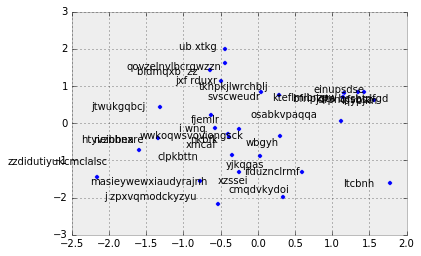

In [41]:
plt.figure()

ax = plt.gca()
point_radius=0.05
renderer = ax.get_figure().canvas.get_renderer()

anchor_x = data[0]
anchor_y = data[1]

ax.scatter(anchor_x, anchor_y)

text_objects = []
anchors = []
other_points = []
for x, y, label in zip(anchor_x, anchor_y, labels):
    point = np.array([x, y])
    if label:
        anchors.append(np.array([x, y]))
        text_objects.append(ax.text(x, y, label))
    else:
        other_points.append(point)

label_bboxes = collect_text_bboxes(text_objects, ax, renderer)
other_bboxes = collect_point_bboxes(anchors + other_points, point_radius=point_radius)

other_bboxes_qtree = make_qtree(other_bboxes)


initial_state = np.zeros(len(label_bboxes) * 2)

adjusted_boxes = adjust_bboxes(step(initial_state), label_bboxes, anchors)
for text, box in zip(text_objects,
                     adjusted_boxes):

    text.set_position([box.x_min, box.y_min])

In [46]:
ans = basinhopping(func, 
                   initial_state, 
                   niter=20,
                   take_step=step,
                   minimizer_kwargs=dict(options=dict(maxiter=10, disp=True)),
                   disp=True)

         Current function value: 59.103998
         Iterations: 8
         Function evaluations: 5276
         Gradient evaluations: 85
basinhopping step 0: f 59.104
         Current function value: 73.912556
         Iterations: 10
         Function evaluations: 868
         Gradient evaluations: 14
basinhopping step 1: f 59.104 trial_f 73.9126 accepted 0  lowest_f 59.104
         Current function value: 83.442407
         Iterations: 5
         Function evaluations: 3294
         Gradient evaluations: 53
basinhopping step 2: f 59.104 trial_f 83.4424 accepted 0  lowest_f 59.104
         Current function value: 74.503813
         Iterations: 6
         Function evaluations: 5091
         Gradient evaluations: 82
basinhopping step 3: f 59.104 trial_f 74.5038 accepted 0  lowest_f 59.104
         Current function value: 81.471112
         Iterations: 7
         Function evaluations: 4471
         Gradient evaluations: 72
basinhopping step 4: f 59.104 trial_f 81.4711 accepted 0  lowest_f 5

In [47]:
ans

                        fun: 59.10399754337973
 lowest_optimization_result:       fun: 59.10399754337973
 hess_inv: array([[ 0.94111372, -0.03750127,  0.02181114, ...,  0.05320083,
        -0.00801651,  0.11272943],
       [-0.03750127,  0.89709607,  0.05224246, ...,  0.07157828,
        -0.01890651,  0.06755583],
       [ 0.02181114,  0.05224246,  0.96280526, ..., -0.05125482,
         0.01379501, -0.09870019],
       ..., 
       [ 0.05320083,  0.07157828, -0.05125482, ...,  1.10252277,
        -0.04062829,  0.12758383],
       [-0.00801651, -0.01890651,  0.01379501, ..., -0.04062829,
         0.97246064, -0.02559859],
       [ 0.11272943,  0.06755583, -0.09870019, ...,  0.12758383,
        -0.02559859,  0.73195666]])
      jac: array([  0.        ,   1.        ,  -1.61719799,   6.79716682,
         0.69671154,   2.3820076 ,   0.11054134,  -1.11718178,
        -2.7065239 ,   4.30053425,   1.13118172,   2.77856541,
         2.97998238,  -0.34597778,   0.77907467,   2.8970747 ,
       

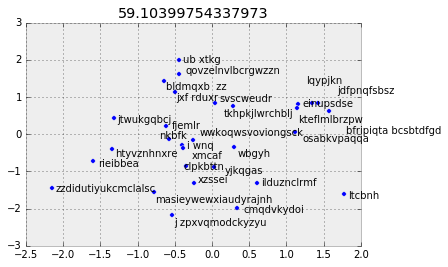

In [48]:
plt.figure()

ax = plt.gca()
point_radius=0.05
renderer = ax.get_figure().canvas.get_renderer()

anchor_x = data[0]
anchor_y = data[1]

ax.scatter(anchor_x, anchor_y)

text_objects = []
anchors = []
other_points = []
for x, y, label in zip(anchor_x, anchor_y, labels):
    point = np.array([x, y])
    if label:
        anchors.append(np.array([x, y]))
        text_objects.append(ax.text(x, y, label))
    else:
        other_points.append(point)

label_bboxes = collect_text_bboxes(text_objects, ax, renderer)
other_bboxes = collect_point_bboxes(anchors + other_points, point_radius=point_radius)

other_bboxes_qtree = make_qtree(other_bboxes)



adjusted_boxes = adjust_bboxes(ans.x, label_bboxes, anchors)
for text, box in zip(text_objects,
                     adjusted_boxes):

    text.set_position([box.x_min, box.y_min])
plt.title(ans.fun)